In [1]:
from split_data import split
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

from base_CNN import Net
from utils import *


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [3]:
source_path = "../Data/Original/Apple"
training_path = "../train_data/"
testing_path = "../test_data/"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting Apple_scab
[Training Samples:441, Testing Samples:189]   Original Samples:630
---------------------
Finish splitting Healthy
[Training Samples:1151, Testing Samples:494]   Original Samples:1645
---------------------
Finish splitting Cedar_apple_rust
[Training Samples:192, Testing Samples:83]   Original Samples:275
---------------------
Finish splitting Black_rot
[Training Samples:435, Testing Samples:186]   Original Samples:621
---------------------
Total Training Samples: 2219, Testing Samples: 952, Total Samples: 3171


In [4]:


# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transforms.Compose([
    transforms.ToTensor()
]))

classes = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


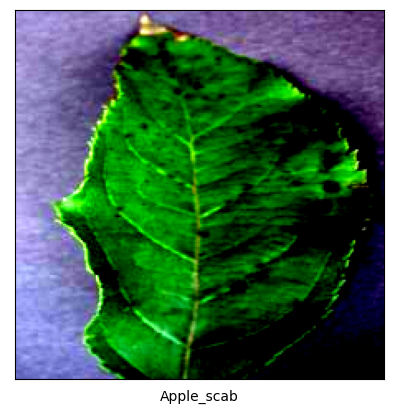

In [5]:
def display_img(img,label):
    plt.imshow(img.permute(1,2,0))
    plt.xlabel(classes[label])
    plt.xticks([])
    plt.yticks([])
    

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=10).permute(1,2,0))
        break

def show_batch_with_labels(dl):
    plt.figure(figsize=(10,10))
    images, labels = next(iter(dl))
    for i in range(25):
        plt.subplot(5,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        display_img(images[i],labels[i].item())
    plt.show()

#display the first image in the dataset
display_img(*train_dataset[0])

print((train_dataset[0][0].size()))

In [6]:
batch_size = 4
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 1775
Length of Validation Data : 444


In [7]:
len(train_dl)

444

In [8]:
# (w - F + 2P)/S + 1

In [9]:

efficient_model = load_efficient_net().to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [10]:
num_classes = len(classes)
efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                test_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5479 | train_acc: 0.8163 | train_f1: 0.8163 | test_loss: 0.2325 | test_acc: 0.9482test_f1: 0.9482 | 
Epoch: 2 | train_loss: 0.3532 | train_acc: 0.8818 | train_f1: 0.8817 | test_loss: 0.1799 | test_acc: 0.9572test_f1: 0.9572 | 
Epoch: 3 | train_loss: 0.3042 | train_acc: 0.8932 | train_f1: 0.8935 | test_loss: 0.1303 | test_acc: 0.9595test_f1: 0.9595 | 
Epoch: 4 | train_loss: 0.2836 | train_acc: 0.9015 | train_f1: 0.9014 | test_loss: 0.1423 | test_acc: 0.9572test_f1: 0.9572 | 
Epoch: 5 | train_loss: 0.2603 | train_acc: 0.9093 | train_f1: 0.9093 | test_loss: 0.1055 | test_acc: 0.9640test_f1: 0.9640 | 
Epoch: 6 | train_loss: 0.2529 | train_acc: 0.9148 | train_f1: 0.9149 | test_loss: 0.1130 | test_acc: 0.9640test_f1: 0.9640 | 
Epoch: 7 | train_loss: 0.2674 | train_acc: 0.9018 | train_f1: 0.9020 | test_loss: 0.1090 | test_acc: 0.9707test_f1: 0.9707 | 
Epoch: 8 | train_loss: 0.2447 | train_acc: 0.9054 | train_f1: 0.9054 | test_loss: 0.1001 | test_acc: 0.9640test_f1: 0.

In [12]:
# accuracy for efficientNet b0
test_run(efficient_model, test_dl, device, batch_size, classes)

samples accuracy: 40.441%
Acc for Class Apple_scab = 13.228%
Acc for Class Black_rot = 5.914%
Acc for Class Cedar_apple_rust = 3.614%
Acc for Class Healthy = 70.040%


In [34]:
# from torcheval.metrics.functional import multiclass_f1_score
# efficient_model.eval()

# test_loss, test_acc, test_f1 = 0, 0, 0
# pred_labels = []
# target_labels = []

# with torch.inference_mode():
#     for _, (X,y) in enumerate(test_dl):
#         X, y = X.to(device), y.to(device)

#         test_pred_logits = efficient_model(X)
#         loss = loss_fn(test_pred_logits, y)
#         test_loss += loss.item()

#         test_pred_labels = test_pred_logits.argmax(dim=1)
        
#         pred_labels = pred_labels + test_pred_labels.tolist()
#         target_labels = target_labels + y.tolist()
        

# print(pred_labels)
# print(target_labels)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 2, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 0, 3, 0, 3, 3, 3, 3, 3, 1, 2, 0, 0, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 

In [36]:
# multiclass_f1_score(torch.tensor(pred_labels), torch.tensor(target_labels), num_classes=4)

tensor(0.4454)

In [13]:
mobile_model = load_mobile_net().to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /Users/afflatus/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 10.0MB/s]


In [16]:
mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

In [17]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.001)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                test_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6439 | train_acc: 0.7686 | test_loss: 0.2373 | test_acc: 0.9482
Epoch: 2 | train_loss: 0.3913 | train_acc: 0.8716 | test_loss: 0.1958 | test_acc: 0.9437
Epoch: 3 | train_loss: 0.3094 | train_acc: 0.8947 | test_loss: 0.1469 | test_acc: 0.9482
Epoch: 4 | train_loss: 0.3138 | train_acc: 0.8866 | test_loss: 0.1137 | test_acc: 0.9775
Epoch: 5 | train_loss: 0.2673 | train_acc: 0.9082 | test_loss: 0.1053 | test_acc: 0.9752
Epoch: 6 | train_loss: 0.2661 | train_acc: 0.9133 | test_loss: 0.0788 | test_acc: 0.9842
Epoch: 7 | train_loss: 0.2501 | train_acc: 0.9060 | test_loss: 0.0813 | test_acc: 0.9797
Epoch: 8 | train_loss: 0.2357 | train_acc: 0.9261 | test_loss: 0.1085 | test_acc: 0.9595
Epoch: 9 | train_loss: 0.2564 | train_acc: 0.9071 | test_loss: 0.0913 | test_acc: 0.9752
Epoch: 10 | train_loss: 0.2735 | train_acc: 0.8992 | test_loss: 0.0797 | test_acc: 0.9752


In [18]:
# MobileNet V2 accuracy
test_run(mobile_model, test_dl, device, batch_size, classes)

samples accuracy: 52.101%
Acc for Class Apple_scab = 0.000%
Acc for Class Black_rot = 0.000%
Acc for Class Cedar_apple_rust = 2.410%
Acc for Class Healthy = 100.000%


In [30]:
from torchsummary import summary

summary(efficient_model.to("cpu"), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [31]:
summary(mobile_model.to("cpu"), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,